# Deep Ensembles

In [20]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.utils.data
from torch import nn
from torch.nn import functional as F

import seaborn as sns

from swag import data, models, utils, losses
from swag.posteriors import SWAG

import tqdm

import os

torch.backends.cudnn.benchmark = True
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

import hamiltorch

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def featurize(x):
    return torch.cat([x[:, None], x[:, None]**2], dim=1)

class RegNet(nn.Sequential):
    def __init__(self, dimensions, input_dim=1, output_dim=1, apply_var=True):
        super(RegNet, self).__init__()
        self.dimensions = [input_dim, *dimensions, output_dim]        
        for i in range(len(self.dimensions) - 1):
            self.add_module('linear%d' % i, torch.nn.Linear(self.dimensions[i], self.dimensions[i + 1]))
            if i < len(self.dimensions) - 2:
                self.add_module('relu%d' % i, torch.nn.ReLU())

        if output_dim == 2:
            self.add_module('var_split', SplitDim(correction=apply_var))

#     def forward(self, x):
#         return super().forward(x)

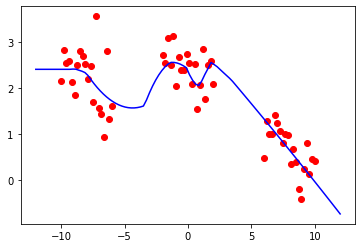

In [8]:
arr = np.load("data.npz") 
x = torch.from_numpy(arr['x'])
f = featurize(x)
y = torch.from_numpy(arr['y']) * 10

x_ = torch.from_numpy(arr['x_'])
f_ = featurize(x_)
y_ = torch.from_numpy(arr['y_']) * 10

plt.plot(x.data.numpy(), y.data.numpy(), "ro")
plt.plot(x_.data.numpy(), y_.data.numpy(), "-b")

In [36]:
def prior(net, prior_var):
    loss = 0.
    for p in net.parameters():
        loss += torch.norm(p)**2 / (2 * prior_var)
    return loss

In [48]:
n_ens = 50
n_steps = 20000
n_data = len(y)

de_all_preds = []
for i in tqdm.tqdm(range(n_ens)):

    net = RegNet(dimensions=[10, 10, 10], input_dim=2)
    optimizer = torch.optim.SGD(net.parameters(), lr=5e-6)
    criterion = torch.nn.functional.mse_loss
    noise_var = 0.0005
    prior_var = 100

    for epoch in range(n_steps):
        optimizer.zero_grad()
        preds = net(f)
        loss = criterion(preds, y) / (2 * noise_var)
        loss += prior(net, prior_var) / n_data 
        loss.backward()
        optimizer.step()

    preds = net(f_).data.numpy()[None, :]
    de_all_preds.append(preds.copy())

de_all_preds = np.vstack(de_all_preds)
# np.save("deep_ensembles_preds", de_all_preds)

100%|██████████| 50/50 [15:29<00:00, 18.58s/it]


(-1, 4)

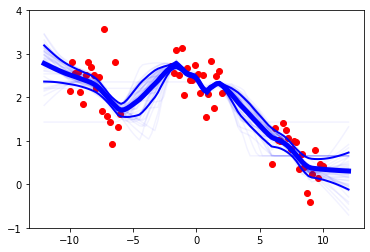

In [63]:
# all_preds = np.vstack([np.load("preds_de_{}.npy".format(i)) for i in range(n_ens)])
all_preds = np.load("deep_ensembles_preds.npy")[:]
pred_mean = all_preds.mean(axis=0)
pred_std = all_preds.std(axis=0)
pred_upper = pred_mean + pred_std
pred_lower = pred_mean - pred_std

plt.plot(x.data.numpy(), y.data.numpy(), "ro")
# plt.plot(x_.data.numpy(), y_.data.numpy(), "--k")
plt.plot(x_.data.numpy(), all_preds[:, :, 0].T, "-b", alpha=0.05);
plt.plot(x_.data.numpy(), pred_mean, "-b", lw=5)
plt.plot(x_.data.numpy(), pred_lower, "-b", lw=2)
plt.plot(x_.data.numpy(), pred_upper, "-b", lw=2)
plt.ylim(-1, 4)